# Advanced RAG: Query Expansion
_by Tuana Celik ([LI](https://www.linkedin.com/in/tuanacelik/),  [Twitter/X](https://x.com/tuanacelik))_

> This is part one of the **Advanced Use Cases** series:
>
> 1️⃣ Extract Metadata from Queries to Improve Retrieval [cookbook](/cookbook/extracting_metadata_filters_from_a_user_query) & [full article](/blog/extracting-metadata-filter)
>
> 2️⃣ **Query Expansion & the [full article](/blog/query-expansion)**
>
> 3️⃣ Query Decomposition [cookbook](/cookbook/query_decomposition) & [full article](/blog/query-decomposition)
>
> 4️⃣ [Automated Metadata Enrichment](/cookbook/metadata_enrichment)

In this cookbook, you'll learn how to implement query expansion for RAG. Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.

📚 [Read the full article](https://haystack.deepset.ai/blog/query-expansion)

In [1]:
!pip install haystack-ai wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=471ec4b854e1b0b710f00ffec2d799097449ce75a3c97ea823015e8a01575a6a
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [2]:
import wikipedia
import json

from typing import List, Optional
from haystack import Pipeline, component

from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.writers import DocumentWriter

from haystack.dataclasses import Document

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

/usr/local/lib/python3.10/dist-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [12]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ['OPENAI_API_KEY'] = getpass("Your OpenAI API Key: ")

Your OpenAI API Key: ··········


## The Process of Query Expansion

First, let's create a `QueryExpander`. This component is going to be able to create a `number` (defaults to 5) of additional queries, similar to the original user query. It returns `queries` that has the original query + `number` of similar queries.

## Retrieval Without Query Expansion

In [18]:
documents = [
    Document(content="The effects of climate are many including loss of biodiversity"),
    Document(content="The impact of climate change is evident in the melting of the polar ice caps."),
    Document(content="Consequences of global warming include the rise in sea levels."),
    Document(content="One of the effects of environmental changes is the change in weather patterns."),
    Document(content="There is a global call to reduce the amount of air travel people take."),
    Document(content="Air travel is one of the core contributors to climate change."),
    Document(content="Expect warm climates in Turkey during the summer period."),
]

doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
doc_store.write_documents(documents)

retriever = InMemoryBM25Retriever(document_store=doc_store, top_k=3)

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("keyword_retriever", retriever)

In [19]:
query = "climate change"
retrieval_pipeline.run({"keyword_retriever":{ "query": query, "top_k": 3}})

{'keyword_retriever': {'documents': [Document(id=8b306c8303c59508a53e5139b4e688c3817fa0211b095bcc77ab3823defa0b32, content: 'Air travel is one of the core contributors to climate change.', score: 2.023895027544814),
   Document(id=aa996058ca5b30d8b469d33e992e094058e707bfb0cf057ee1d5b55ac4320234, content: 'The impact of climate change is evident in the melting of the polar ice caps.', score: 1.8661960327485192),
   Document(id=4d5f7ef8df12c93cb5728cc0247bf95282a14017ce9d0b35486091f8972347a5, content: 'The effects of climate are many including loss of biodiversity', score: 1.5532314806726806)]}}

In [20]:
simple_rag_pipeline = retrieval_pipeline

openai_gen_comp = OpenAIGenerator()

simple_rag_pipeline.add_component("llm", openai_gen_comp)
simple_rag_pipeline.run({"keyword_retriever":{ "query": query, "top_k": 3}, "llm": {"prompt": "Wie sieht es derzeit um den Klimawandel aus?"}})

{'keyword_retriever': {'documents': [Document(id=8b306c8303c59508a53e5139b4e688c3817fa0211b095bcc77ab3823defa0b32, content: 'Air travel is one of the core contributors to climate change.', score: 2.023895027544814),
   Document(id=aa996058ca5b30d8b469d33e992e094058e707bfb0cf057ee1d5b55ac4320234, content: 'The impact of climate change is evident in the melting of the polar ice caps.', score: 1.8661960327485192),
   Document(id=4d5f7ef8df12c93cb5728cc0247bf95282a14017ce9d0b35486091f8972347a5, content: 'The effects of climate are many including loss of biodiversity', score: 1.5532314806726806)]},
 'llm': {'replies': ['Der Klimawandel bleibt ein zentrales globales Problem, das durch den Anstieg der Treibhausgase in der Atmosphäre, vor allem CO₂, Methan und Lachgas, verursacht wird. Trotz internationaler Bemühungen, wie dem Pariser Abkommen von 2015, zeigen die aktuellen Daten, dass die globalen Temperaturen weiterhin steigen. \n\nHier sind einige der wesentlichen Entwicklungen und Aspekte 

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we are to inluce query expansion in the process. For this step, let's create a `MultiQueryInMemoryBM25Retriever` that is able to use BM25 retrieval for each (expansded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [21]:
retrieval_pipeline.dumps()

'components:\n  keyword_retriever:\n    init_parameters:\n      document_store:\n        init_parameters:\n          bm25_algorithm: BM25L\n          bm25_parameters: {}\n          bm25_tokenization_regex: (?u)\\b\\w\\w+\\b\n          embedding_similarity_function: cosine\n          index: 76b6425f-b990-4f04-a100-a90fb26fd21c\n        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore\n      filter_policy: replace\n      filters: null\n      scale_score: false\n      top_k: 3\n    type: haystack.components.retrievers.in_memory.bm25_retriever.InMemoryBM25Retriever\n  llm:\n    init_parameters:\n      api_base_url: null\n      api_key:\n        env_vars:\n        - OPENAI_API_KEY\n        strict: true\n        type: env_var\n      generation_kwargs: {}\n      model: gpt-4o-mini\n      organization: null\n      streaming_callback: null\n      system_prompt: null\n    type: haystack.components.generators.openai.OpenAIGenerator\nconnections: []\nmax_runs_per_compo

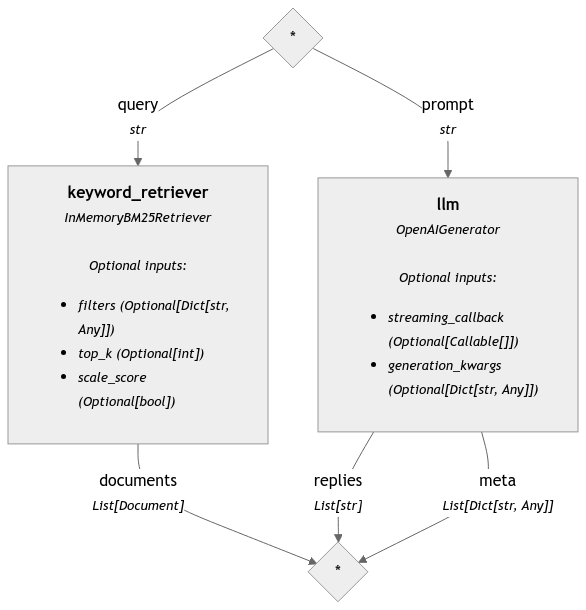

In [22]:
retrieval_pipeline.show()

In [ ]:
query_expanded_rag_pipeline.run({"query": "green energy sources", "top_k": 3}, include_outputs_from=["keyword_retriever", "expander"])

{'llm': {'replies': ['Green energy sources refer to renewable energy from natural resources like wind power and electric vehicles that use electric motors for propulsion. This type of energy is sustainable and replenished over time, unlike fossil fuels or nuclear power. [Source: Wikipedia]'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 47,
     'prompt_tokens': 1242,
     'total_tokens': 1289}}]},
 'expander': {'queries': ['renewable energy sources',
   'sustainable energy options',
   'alternative energy sources',
   'environmentally friendly energy sources',
   'clean energy alternatives',
   'green energy sources']},
 'keyword_retriever': {'documents': [Document(id=03a55d98ad5f0fa8f849dd179913f9ffc25c9aad8aa11722a79df915356b1113, content: 'An electric battery is a source of electric power consisting of one or more electrochemical cells wi...', meta: {'title': 'Electric battery', 'url': 'https://en.wik